In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install phrasemachine

     |████████████████████████████████| 2.7MB 8.4MB/s 
  Created wheel for phrasemachine: filename=phrasemachine-1.0.7-cp37-none-any.whl size=2694882 sha256=c8c0f095734e3d798394628efcdab928f1ed772fa59acde784dc27a02714a0e1
  Stored in directory: /root/.cache/pip/wheels/dd/9b/97/55e03013915dde1b059f16364f54a553f2e1d94dc046285a4a
Successfully built phrasemachine


In [4]:
pip install rake_nltk

  Created wheel for rake-nltk: filename=rake_nltk-1.0.4-py2.py3-none-any.whl size=7819 sha256=693206f5c9becdf653bd98ff616118924196f5446791596718e60b93c51d63e5
  Stored in directory: /root/.cache/pip/wheels/ef/92/fc/271b3709e71a96ffe934b27818946b795ac6b9b8ff8682483f
Successfully built rake-nltk


In [5]:
###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk import ngrams, FreqDist
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import TSNE

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import pandas as pd
import os
import numpy as np
import phrasemachine
from rake_nltk import Rake
import re
import matplotlib.pyplot as plt
from numpy import array
from numpy import argmax
import gensim

In [6]:
#load class corpus
data=pd.read_csv(r'/content/drive/MyDrive/2021_Spring_453_Sec56_Class_Corpus-4.csv')
data

,Doc_ID,DSI_Title,Text
0,0,BJL_Doc3_Having-received-a.txt,Having received a mysterious signal emanating ...
1,1,BJL_Doc2_An-exploration-of.txt,TL;DR – An exploration of a film that effortle...
2,2,BJL_Doc6_TRON-Legacy-is.txt,‘TRON: Legacy’ is the sequel to the 1982 film ...
3,3,BJL_Doc1_So-when-I.txt,So when I say that Tron: Legacy had me on the ...
4,4,BJL_Doc5_The_addition_of.txt,"The addition of that stately ""legacy"" to the t..."
...,...,...,...
72,72,SCFIDRJ_Doc3_The_Matrix.txt,"""The Matrix,"" with Keanu Reeves, Laurence Fish..."
73,73,SCFIDRJ_Doc4_I_Robot.txt,"'I, Robot"" takes place in Chicago circa 2035, ..."
74,74,SCFIDRJ_Doc5_Ex_Machina.txt,"After a recent run ofoverly-hyped, butultimate..."
75,75,SCFIDRJ_Doc6_Her.txt,"Spike Jonze's ""Her"" plays like a kind of mirac..."


In [13]:
for i in range(0, len(data['Text'])):
  print(data['Text'][i])

Having received a mysterious signal emanating from his father’s arcade, Sam sets off to investigate, and following a few brief key presses on an old computer terminal, he too finds himself locked inside the Grid.

Almost like an atonement for the lengthy scene-setting that forms Legacy’s opening, Kosinski has Sam kinkily stripped out of his civilian wear, zipped into a skin-tight costume made of rubber and glowsticks, and throws him into a series of Tron-referencing gladiatorial games, beginning with a high-velocity tournament with deadly discs, and then a dizzying Light Cycle chicken run, before he’s whisked away by slinky heroine Quorra.

Quorra, played with feline innocence by Olivia Wilde, is a warrior program who, like Sam, is dangerously multi-talented, and as at home talking about 20th century literature as she is driving an off-road vehicle or smashing opponents into cubes with fists and feet. Whisking Sam off the Grid, Quorra ushers Sam to a refuge in the world’s digital wilde

In [18]:
#Custom functions required as part of demonstration
#functions used to process text and create the required TFIDF and Doc2vec Matrices
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

def tfidf(corpus, titles, ngram_range):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range)

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    #words = Tfidf.get_feature_names()
    #matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return TFIDF_matrix.toarray()


def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels


In [37]:
#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))



#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()


#generate tfidf for analysis
tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,10))

In [39]:
# Doing Classification .... First Label Dataset

labels = ['Disney', 'Disney', 'Disney', 'Disney', 'Disney', 'Disney', 'Disney', 'Hero', 'Horror', 
                       'Justice', 'Sports', 'Sports', 'Hero', 'Love', 'Hero', 'War', 'Horror', 'Horror', 'Horror', 
                        'Magic', 'Horror', 'Science-Fiction', 'Love', 'War', 'Science-Fiction', 'Sports', 'Love', 
                        'Horror', 'War', 'Sports', 'Comedy', 'Time', 'Science-Fiction', 'War', 'Science-Fiction', 
          'Hero', 'Sports', 'Hero', 'Science-Fiction', 'Science-Fiction', 'Sports', 'Science-Fiction', 'Hero', 
          'Science-Fiction', 'Science-Fiction', 'Science-Fiction', 'War', 'War', 'War', 'Science-Fiction', 'Thriller', 
          'Science-Fiction', 'War', 'Sports', 'Love', 'Love', 'Love', 'Science-Fiction', 'India', 'Horror', 'Sports', 
          'Love', 'Love', 'Disney', 'Disney', 'Disney', 'Disney', 'Disney', 'Disney', 'Disney', 'Science-Fiction', 
          'Science-Fiction', 'Science-Fiction', 'Science-Fiction', 'Science-Fiction', 'Science-Fiction', 'Science-Fiction']
# encoding labels for classification
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
data['Labels']= le.transform(labels)
data

,Doc_ID,DSI_Title,Text,processed_text,Labels
0,0,BJL_Doc3_Having-received-a.txt,Having received a mysterious signal emanating ...,"[received, mysterious, signal, emanating, arca...",1
1,1,BJL_Doc2_An-exploration-of.txt,TL;DR – An exploration of a film that effortle...,"[exploration, effortless, blends, music, visua...",1
2,2,BJL_Doc6_TRON-Legacy-is.txt,‘TRON: Legacy’ is the sequel to the 1982 film ...,"[sequel, stars, bridges, garrett, hedlund, oli...",1
3,3,BJL_Doc1_So-when-I.txt,So when I say that Tron: Legacy had me on the ...,"[legacy, impressed, special, effects, action, ...",1
4,4,BJL_Doc5_The_addition_of.txt,"The addition of that stately ""legacy"" to the t...","[addition, stately, legacy, title, strains, co...",1
...,...,...,...,...,...
72,72,SCFIDRJ_Doc3_The_Matrix.txt,"""The Matrix,"" with Keanu Reeves, Laurence Fish...","[matrix, keanu, reeves, laurence, fishburne, c...",8
73,73,SCFIDRJ_Doc4_I_Robot.txt,"'I, Robot"" takes place in Chicago circa 2035, ...","[robot, takes, place, chicago, circa, spectacu...",8
74,74,SCFIDRJ_Doc5_Ex_Machina.txt,"After a recent run ofoverly-hyped, butultimate...","[recent, ofoverlyhyped, butultimatelydisappoin...",8
75,75,SCFIDRJ_Doc6_Her.txt,"Spike Jonze's ""Her"" plays like a kind of mirac...","[spike, jonzes, plays, miracle, first, around,...",8


In [40]:
for i in range(0, len(data['processed_text'])):
  print(data['processed_text'][i])

['received', 'mysterious', 'signal', 'emanating', 'arcade', 'investigate', 'following', 'brief', 'presses', 'computer', 'terminal', 'finds', 'locked', 'inside', 'almost', 'atonement', 'lengthy', 'scenesetting', 'forms', 'opening', 'kosinski', 'kinkily', 'stripped', 'civilian', 'zipped', 'skintight', 'costume', 'rubber', 'glowsticks', 'throws', 'series', 'tronreferencing', 'gladiatorial', 'games', 'beginning', 'highvelocity', 'tournament', 'deadly', 'discs', 'dizzying', 'light', 'cycle', 'chicken', 'whisked', 'slinky', 'heroine', 'quorra', 'quorra', 'played', 'feline', 'innocence', 'olivia', 'wilde', 'warrior', 'program', 'dangerously', 'multitalented', 'talking', 'century', 'literature', 'driving', 'offroad', 'vehicle', 'smashing', 'opponents', 'cubes', 'fists', 'whisking', 'quorra', 'ushers', 'refuge', 'digital', 'wilderness', 'father', 'kevin', 'zenlike', 'trance', 'learn', 'little', 'backstory', 'advanced', 'program', 'rogue', 'turning', 'fascist', 'state', 'subjugating', 'populace'

In [41]:
def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

integerMapping = get_integer_mapping(le)
{"Disney": integerMapping['Disney'], "Thriller": integerMapping['Thriller'], "Magic": integerMapping['Magic'], "Hero": integerMapping['Hero'], "Justice": integerMapping['Justice'], 
 "Comedy": integerMapping['Comedy'], "India": integerMapping['India'], "Horror": integerMapping['Horror'], "Sports": integerMapping['Sports'], "Love": integerMapping['Love'], 
 "Science-Fiction": integerMapping['Science-Fiction'], "War" : integerMapping['War'],  "Time" : integerMapping['Time']}

{'Comedy': 0,
 'Disney': 1,
 'Hero': 2,
 'Horror': 3,
 'India': 4,
 'Justice': 5,
 'Love': 6,
 'Magic': 7,
 'Science-Fiction': 8,
 'Sports': 9,
 'Thriller': 10,
 'Time': 11,
 'War': 12}

In [22]:
type(data['Labels'])

pandas.core.series.Series

In [23]:
tfidf_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

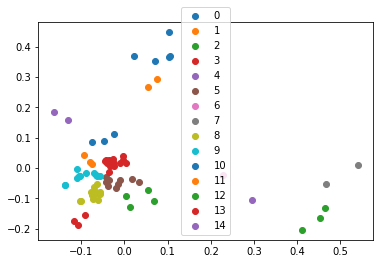

In [24]:
#Importing required modules
 
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
 
#Load Data
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(tfidf_matrix)
 
#Import KMeans module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 15)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()



# Support Vector Machines

In [46]:
#split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix , data['Labels'], test_size=0.4, random_state=0)

In [47]:
from sklearn.svm import SVC
model = SVC(kernel="poly")
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [48]:
  #NOTE THIS IS AN OVERFIT CASE SO YOU KNOW THAT IT IS WORKING
    #ONCE YOU GET CLOSE TO 100% ACCURACY THEN COMMENT OUT THESE TWO LINES
predictions = model.predict(X_train)
accy = accuracy_score(y_train, predictions)
    #NOTE THIS IS THE CORRECT WAY TO TEST YOUR CLASSIFIERS
    #UNCOMMENT THESE TWO LINES ONCE THE OVERFIT CASE YIELDS CLOSE TO 100% ACCURACY
    #predictions = model.predict(X_test)
    #accy = accuracy_score(y_test, predictions)
print(accy)
predictionstest = model.predict(X_test)
acctest = accuracy_score(y_test, predictionstest)
print(acctest)

1.0
0.2903225806451613


# Random Forests

In [55]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [56]:
predictions = classifier.predict(X_train)
accy = accuracy_score(y_train, predictions)
accy

1.0

In [57]:
y_pred = classifier.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.45161290322580644


In [58]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [59]:
predictions = classifier.predict(X_train)
accy = accuracy_score(y_train, predictions)
accy

1.0

In [60]:
y_pred = classifier.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.45161290322580644


In [61]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [62]:
y_pred = classifier.predict(X_train)
print(accuracy_score(y_train, y_pred))

1.0


In [63]:
y_pred = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.45161290322580644


# ALSO APPLIED LABELS USING K MEANS; K = 15 PRODUCED HIGHEST ACCURACY

In [64]:
#Section 1: K-Means
def k_means(titles, tfidf_matrix, k):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    print(cluster_title)
    return cluster_title,clusters,frame

In [65]:
#Section 1: Execute K-means clustering
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k = 15)

#labels used for supervised learning
labels = k_means_df['Cluster']

{0: ['MSS_Doc4_Troy-Is-Based.docx', 'EG_Doc2_This_Time_Dream.docx', 'MSS_Doc6_Having-Become-The.docx', 'CVN_Doc3_The_CIA_Agent.docx'], 1: ['BJL_Doc3_Having-received-a.txt', 'BJL_Doc2_An-exploration-of.txt', 'BJL_Doc6_TRON-Legacy-is.txt', 'BJL_Doc1_So-when-I.txt', 'BJL_Doc5_The_addition_of.txt', 'BJL_Doc4_The-good-news.txt', 'BJL_Doc7_Both-Blade-Runner.txt', 'MSS_Doc3_That-Old-Time.docx', 'WS_DOC1_Tenet.docx', 'GS_DOC6_Hidden_Figures_Review.docx', 'EG_Doc1_When_Traveling.docx', 'MSS_Doc5_When-Dune-The.docx'], 2: ['CVN_Doc7_1917.docx', 'EG_Doc3_Epic_Intimacy_Arrival.docx', 'CVN_Doc5_Dunkirk_Film_Review.docx', 'CVN_Doc2_Film_Review_Panoramic.docx'], 3: ['GS_DOC5_Delightfully_smart_exciting.docx', 'MSS_Doc2_As-Possibly-Cinema_s.docx', 'SCFIDRJ_Doc4_I_Robot.txt', 'SCFIDRJ_Doc5_Ex_Machina.txt'], 4: ['RC_Doc5_I_went_into.docx', 'RC_Doc3_The_witch_a.docx', 'RC_Doc4_Were_instinctively_afraid.docx', 'CVN_Doc1_To_Hell_With.docx', 'CVN_Doc4_Pearl_Harbor.docx', 'SIM_Doc5_Movie_MS_Dhoni.docx', 'RC_D

In [98]:
#split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix , labels, test_size=0.10, random_state=0)

In [111]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [112]:
predictions = classifier.predict(X_train)
accy = accuracy_score(y_train, predictions)
accy

1.0

In [113]:
y_pred = classifier.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.75


In [114]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1]])

In [89]:
model = SVC(kernel="rbf")
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [90]:
  #NOTE THIS IS AN OVERFIT CASE SO YOU KNOW THAT IT IS WORKING
    #ONCE YOU GET CLOSE TO 100% ACCURACY THEN COMMENT OUT THESE TWO LINES
predictions = model.predict(X_train)
accy = accuracy_score(y_train, predictions)
    
    #NOTE THIS IS THE CORRECT WAY TO TEST YOUR CLASSIFIERS
    #UNCOMMENT THESE TWO LINES ONCE THE OVERFIT CASE YIELDS CLOSE TO 100% ACCURACY
    #predictions = model.predict(X_test)
    #accy = accuracy_score(y_test, predictions)
print(accy)
predictionstest = model.predict(X_test)
acctest = accuracy_score(y_test, predictionstest)
print(acctest)

1.0
0.1935483870967742


In [107]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [108]:
predictions = classifier.predict(X_train)
accy = accuracy_score(y_train, predictions)
accy

1.0

In [109]:
y_pred = classifier.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.75


In [110]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1]])

In [94]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [95]:
y_pred = classifier.predict(X_train)
print(accuracy_score(y_train, y_pred))

1.0


In [96]:
y_pred = classifier.predict(X_test)

In [103]:
print(accuracy_score(y_test, y_pred))

0.75


In [106]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1]])

# Trying Neural Networks

In [79]:
#split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix , labels, test_size=0.5, random_state=0)

In [81]:
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

input_dim = X_train[0].shape
print(input_dim)  # Number of features
model = Sequential()
model.add(layers.Dense(128, input_shape=input_dim, activation='relu'))
model.add(layers.Dense(128, input_shape=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))

(7099,)


In [82]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               908800    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 925,441
Trainable params: 925,441
Non-trainable params: 0
_________________________________________________________________


In [83]:
history = model.fit(X_train, y_train,
                    epochs=125,
                    verbose=True,
                    validation_data=(X_test, y_test))

Epoch 1/125
2/2 [==============================] - 3s 325ms/step - loss: 0.0000e+00 - accuracy: 0.1398 - val_loss: 0.0000e+00 - val_accuracy: 0.1795
Epoch 2/125
2/2 [==============================] - 0s 37ms/step - loss: 0.0000e+00 - accuracy: 0.1294 - val_loss: 0.0000e+00 - val_accuracy: 0.1795
Epoch 3/125
2/2 [==============================] - 0s 36ms/step - loss: 0.0000e+00 - accuracy: 0.1398 - val_loss: 0.0000e+00 - val_accuracy: 0.1795
Epoch 4/125
2/2 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - accuracy: 0.1190 - val_loss: 0.0000e+00 - val_accuracy: 0.1795
Epoch 5/125
2/2 [==============================] - 0s 35ms/step - loss: 0.0000e+00 - accuracy: 0.1294 - val_loss: 0.0000e+00 - val_accuracy: 0.1795
Epoch 6/125
2/2 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - accuracy: 0.1294 - val_loss: 0.0000e+00 - val_accuracy: 0.1795
Epoch 7/125
2/2 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - accuracy: 0.1190 - val_los

In [84]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.1316
Testing Accuracy:  0.1795
